# L'objectif

Pour n = 100 joueurs de tennis on dispose de p = 6 statistiques : pourcentage de 1er services réussis, de balles de break sauvées, etc. Le but est d'analyser ces données de façon automatique :
  - les représenter graphiquement de façon pertinente,   
  - déterminer des corrélations entre variables,
  - classer les joueurs en di érentes catégories.

In [1]:
import csv

import numpy as np

import cv2

import matplotlib.pyplot as plt

In [2]:
def extractioncsv(fichiercsv):
    liste = []
    
    with open(fichiercsv, encoding='utf8') as fcsv:
        lecteur = csv.reader(fcsv, delimiter=';')
        for ligne in lecteur:
            liste.append(ligne)
    return liste

In [3]:
TennisChiffres=extractioncsv("TennisChiffresTop100_2018.csv")

In [4]:
# nom des joueurs
list_nom = []
for i in range(99):
    list_nom.append(TennisChiffres[i+1][0])

In [5]:
# convert data from string to numpy array
data = np.zeros((99,6))
for i in range(1,100):
    for j in range(1,7):
        data[i-1, j-1] = int(TennisChiffres[i][j])

## Visualisation : Analyse en Composantes Principales

On note Xi,j la j-ème statistique du joueur i. Les données sont donc formées de n points dans Rp, on souhaite les représenter dans R2 de la façon la plus pertinente possible.

La matrice  X_nor.T*X_nor est la matrice p × p des corrélations, elle est symétrique positive, donc diagonalisable de
valeurs propres réelles positives λ1 ≥ · · · ≥ λp ≥ 0. On peut par ailleurs la diagonaliser dans une base orthogonale u1, . . . , up.

In [6]:
# data normalization
data_nor = (data-np.mean(data, axis=0))/ np.std(data,axis=0)

In [7]:
# calcul correlation between six features
corr = np.dot(data_nor.T, data_nor)/99

In [8]:
print(corr)

[[ 1.         -0.77765694  0.54796396 -0.66101629  0.37988454 -0.53184847]
 [-0.77765694  1.         -0.44626725  0.74093065 -0.3252793   0.65025705]
 [ 0.54796396 -0.44626725  1.         -0.43164907  0.34873119 -0.57721781]
 [-0.66101629  0.74093065 -0.43164907  1.         -0.23840842  0.68520568]
 [ 0.37988454 -0.3252793   0.34873119 -0.23840842  1.         -0.32910091]
 [-0.53184847  0.65025705 -0.57721781  0.68520568 -0.32910091  1.        ]]


Le point de vue de l'ACP est de chercher le vecteur u = (u1, . . . , up) ∈ Rp tel que la projection du nuage de points sur u ait une inertie maximale

### Théorème 1 
Soit X = (X1, . . . , Xp) une variable aléatoire à valeurs dans $R^p$, le vecteur propre u1 = (u1, . . . , u1p) associé à λ1 est le vecteur qui maximise u  → Var(< X, u >).
De même, le vecteur propre u2 associé à λ2 est celui qui maximise Var(< X,u2 >) parmi les vecteurs orthogonaux à u1.

In [9]:
eigv, eigvec = np.linalg.eig(corr)

In [11]:
# Attention: np.linalg.eig envoie vecteurs propres en colone
eigvec = eigvec.T[np.argsort(eigv)]
eigv = eigv[np.argsort(eigv)]

In [14]:
u1 = eigvec[-1, :]
u2 = eigvec[-2, :]

In [16]:
proj1 = np.dot(data, u1)

proj2 = np.dot(data, u2)

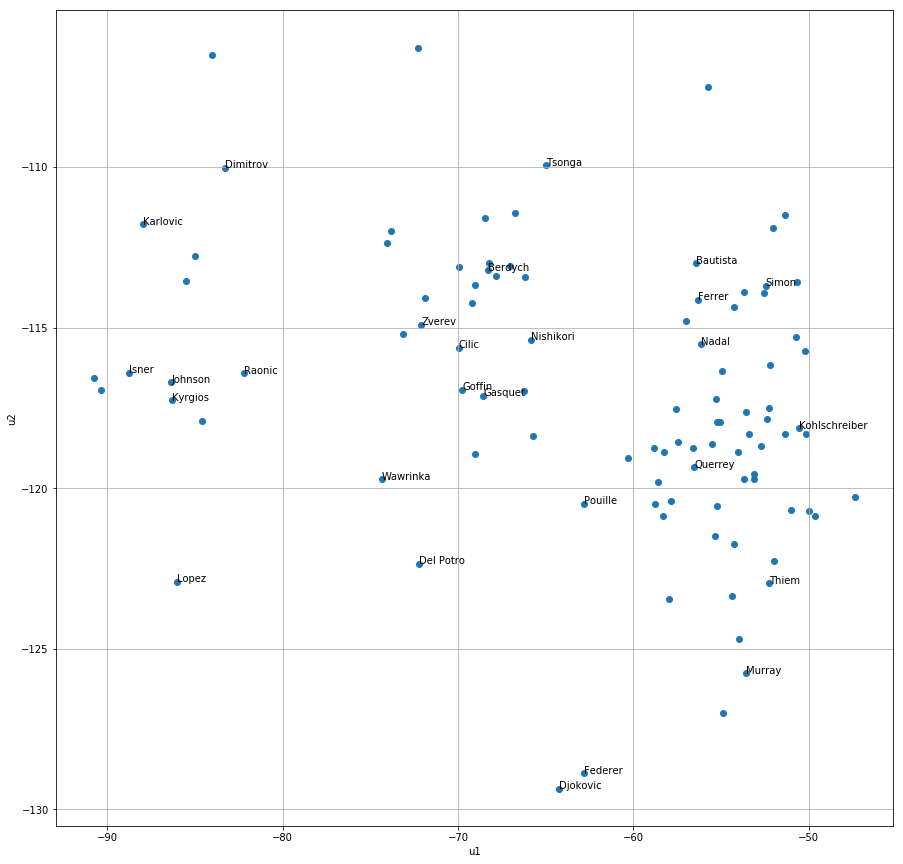

In [17]:
plt.figure(figsize=(15,15))
plt.scatter(proj1, proj2)
for i in range(99):
    plt.annotate(list_nom[i], (proj1[i], proj2[i]))
plt.xlabel('u1')
plt.ylabel('u2')
plt.grid()
plt.show()

### Disque des corrélations
Pour un paramètre i ≤ p, on pose
$r_{i,1} = u^{1}_{i} \sqrtλ_{1} , r_{i,2} = u^{2}_{i} \sqrtλ_{2} $.

Tracer les p points de coordonnées ($r_{i,1},r_{i,2}$) ainsi que le cercle unité.
Les points Ai = ($r_{i,1}, r_{i,2}$) se trouvent à l'intérieur du cercle unité. Le dessin obtenu s'interprète de la
façon suivante : les variables signi catives se trouvent au bord du cercle

In [18]:
r1 = np.sqrt(eigv[-1])*u1

r2 = np.sqrt(eigv[-2])*u2

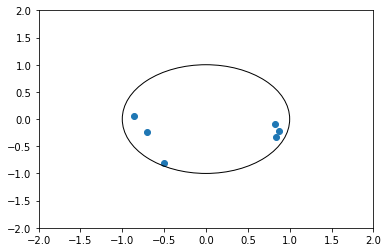

In [19]:
fig, ax = plt.subplots()
plt.xlim([-2,2])
plt.ylim([-2,2])
ax.add_artist(plt.Circle((0,0), 1, fill=False))
plt.scatter(r1, r2)
plt.show()

In [20]:
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [21]:
k = 3 # k clusters
# Initial Points
# X coordinates of k random centroids
C_x = np.random.randint(np.min(proj1), np.max(proj1), size=k)
# Y coordinates of k random centroids
C_y = np.random.randint(np.min(proj2), np.max(proj2), size=k)
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
print(C)

[[ -62. -126.]
 [ -89. -107.]
 [ -59. -116.]]


In [39]:
C_old = np.zeros_like(C)
# Cluster lables(0, 1, 2)
number_points = data.shape[0]
clusters = np.zeros(number_points)
# Error func. - Distance between new centroids and old centroids
error = np.mean(np.linalg.norm(C-C_old, axis=1))
# Loop will run till the error smaller than epsilon
epsilon = 0.001

In [23]:
# projection data onto new sapce

u1_ = np.expand_dims(u1, axis=-1)
u2_ = np.expand_dims(u2, axis=-1)
new_space = np.concatenate((u1_,u2_),axis=1)

data_proj = np.dot(data, new_space)

In [41]:
# Clustering...

while error > epsilon:
    
    print('training ...')
    for i in range(number_points):
        distances = dist(data_proj[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    
    C_old = np.copy(C)
    
    # Calcul new centroids according to current clusters
    for i in range(k):
        points = [data_proj[j] for j in range(number_points) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    
    error = np.mean(np.linalg.norm(C-C_old, axis=1))

training ...
training ...
training ...
training ...
training ...
training ...
training ...
training ...
training ...


### Visualization of clusters

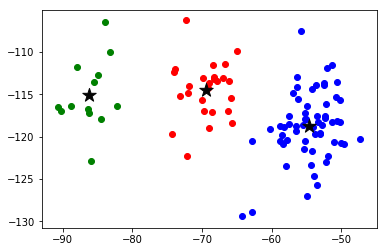

In [43]:
colors = ['r', 'g', 'b']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([data_proj[j] for j in range(number_points) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=None, c=colors[i])
ax.scatter(C[:, 0], C[:, 1], marker='*', s=200, c='#050505')
plt.show()